<h1> LLM Generated Text Detection </h1>

This program is an implementation of a detector of LLM-generated text. <br>
To train this detector(model), we used a dataset called "ChatGPT Classification Dataset". <br>
dataset link : https://www.kaggle.com/datasets/mahdimaktabdar/chatgpt-classification-dataset?select=article_level_data.csv


In [44]:
import pandas as pd

# load the dataset into a pandas dataframe
data = pd.read_csv("article_level_data.csv")
data.head()

,Unnamed: 0,article,class
0,0,NLP is a multidisciplinary field that draws fr...,0
1,1,There are a variety of emerging applications f...,0
2,2,As each new means of communication and social ...,0
3,3,"These suggestions include:, Learn about the pu...",0
4,4,In recent years there has been growing concern...,0


In [45]:
# delete useless columns
data.drop('Unnamed: 0', axis=1, inplace=True)

In [46]:
# divide data into X and Y (features and target)
X = data['article']
Y = data['class']

X.head()

0    NLP is a multidisciplinary field that draws fr...
1    There are a variety of emerging applications f...
2    As each new means of communication and social ...
3    These suggestions include:, Learn about the pu...
4    In recent years there has been growing concern...
Name: article, dtype: object

<h3> 1- Data Analysis </h3>

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

data['article_length'] = data['article'].apply(len)

"""
#compare the length of article generated by humain and AI
sns.histplot(data[data['class'] == 0]['article_length'], color="orange", label='Human-generated', kde=True)
sns.histplot(data[data['class'] == 1]['article_length'], color="blue", label='AI-generated', kde=True)
plt.title('Distribution of article Lengths')
plt.xlabel('article Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
"""

'\n#compare the length of article generated by humain and AI\nsns.histplot(data[data[\'class\'] == 0][\'article_length\'], color="orange", label=\'Human-generated\', kde=True)\nsns.histplot(data[data[\'class\'] == 1][\'article_length\'], color="blue", label=\'AI-generated\', kde=True)\nplt.title(\'Distribution of article Lengths\')\nplt.xlabel(\'article Length (Number of Characters)\')\nplt.ylabel(\'Frequency\')\nplt.legend()\nplt.show()\n'

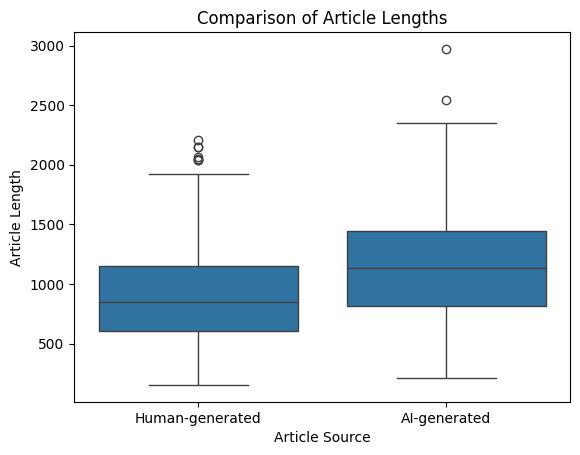

In [48]:
#compare the diffrence of length bewteen article with box plot 
sns.boxplot(x='class', y='article_length', data=data)
plt.title('Comparison of Article Lengths')
plt.xlabel('Article Source')
plt.ylabel('Article Length')
plt.xticks([0, 1], ['Human-generated', 'AI-generated'])
plt.show()

In [49]:
from collections import Counter
#compare the most common words appeared in the article generated by ai and human
def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)

    # Plot the most common words
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

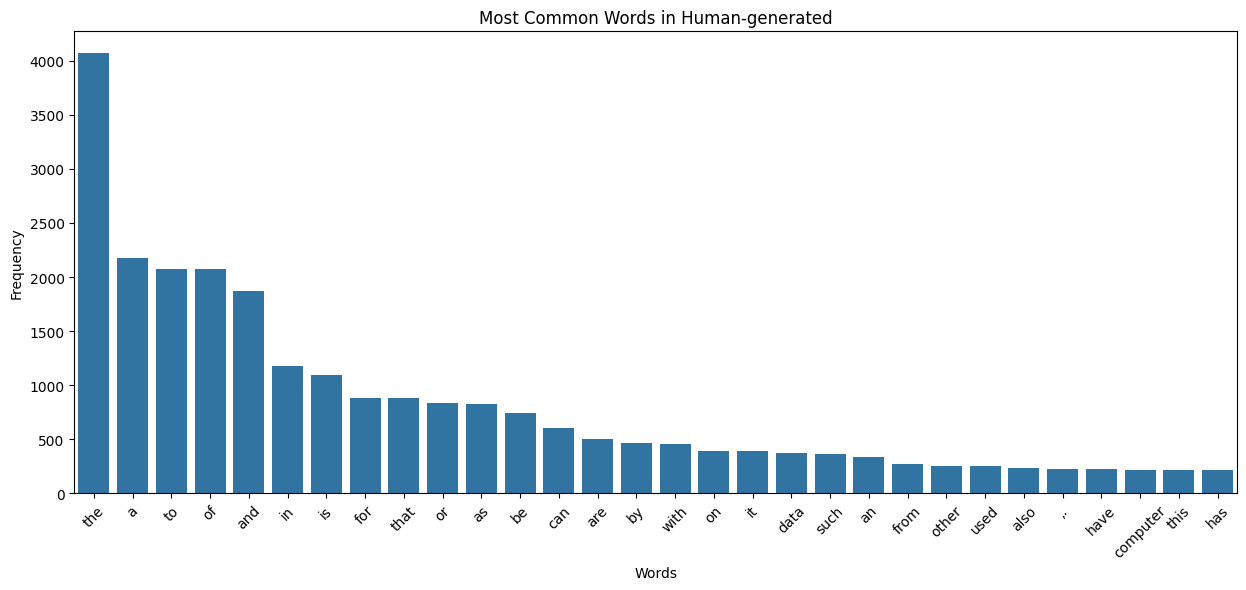

In [50]:
plot_most_common_words(data[data['class'] == 0]['article'], title="Most Common Words in Human-generated")


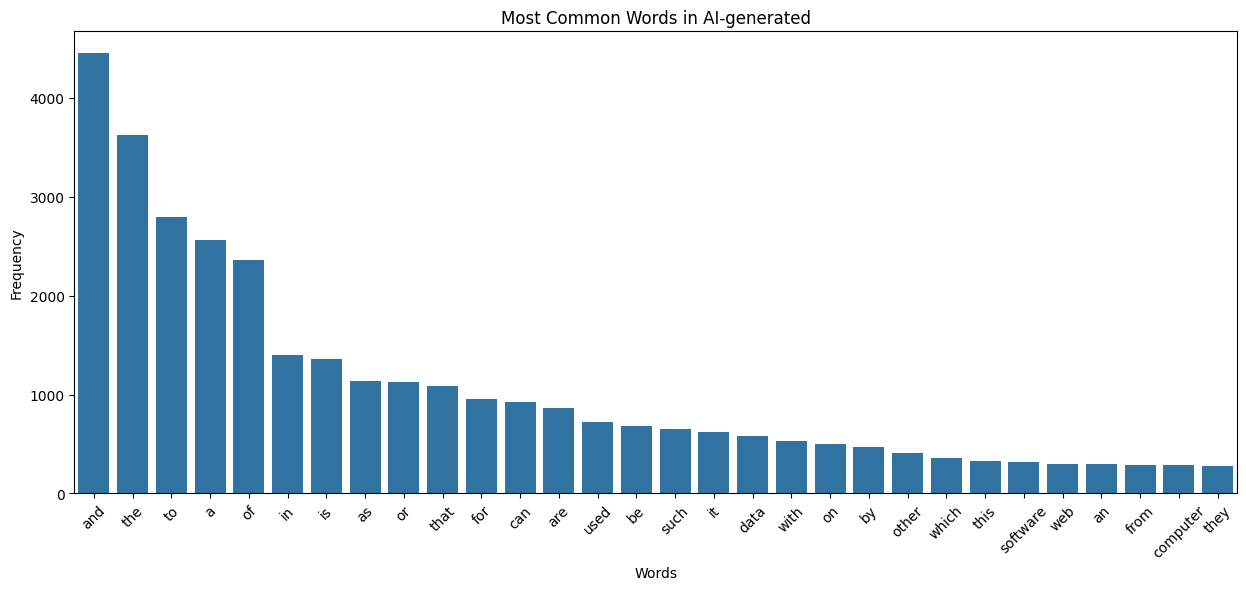

In [51]:
plot_most_common_words(data[data['class'] == 1]['article'], title="Most Common Words in AI-generated")

In [52]:
import string

#Compare  the  most used punctuation marks in human-generated and AI-generated texts
def count_punctuation(text):
    punctuation_count = Counter(char for char in text if char in string.punctuation)
    return punctuation_count

# Count punctuation in each text
data['punctuation_count'] = data['article'].apply(count_punctuation)

# Separate counts by class
human_punctuations = data[data['class'] == 0]['punctuation_count'].sum()
ai_punctuations = data[data['class'] == 1]['punctuation_count'].sum()

human_punctuations = {k: v for k, v in human_punctuations.items() if v > 100}
ai_punctuations = {k: v for k, v in ai_punctuations.items() if v > 100}


# Create a DataFrame for plotting
plot_data = pd.DataFrame([human_punctuations, ai_punctuations], index=['Human', 'AI'])



Text(0.5, 0, 'Source')

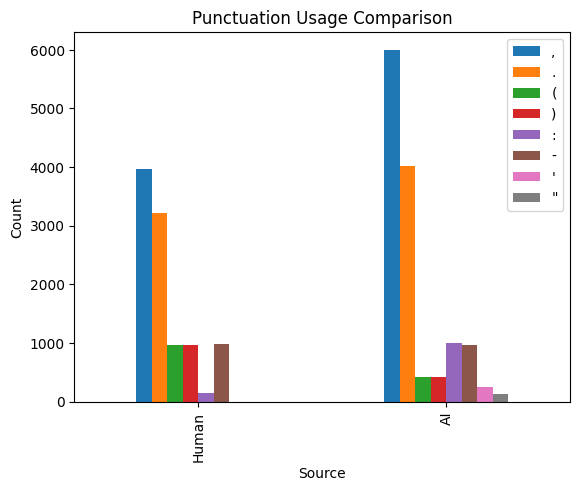

In [53]:
# show figure 
plot_data.plot(kind='bar')
plt.title('Punctuation Usage Comparison')
plt.ylabel('Count')
plt.xlabel('Source')

<h3> 2- Vectorization (Preprocessing) </h3>

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

# data vectorization witch Tfidf
vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, stop_words=None, max_features=20000)
X_vec = vectorizer.fit_transform(X)

# print results of vectorization
print(X_vec.shape)
print(type(X_vec))
print(X_vec.toarray())


(1018, 20000)
<class 'scipy.sparse._csr.csr_matrix'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
# don't increase the precision of the model :(

"""
# feature engineering
docLength = data['article'].str.len().values[:,None]
# normalise docLength [0,1]
docLength = (docLength - docLength.min()) / (docLength.max() - docLength.min())

# add docLength to X_vec
X_vec = np.hstack((X_vec.toarray(), docLength))
"""

"\n# feature engineering\ndocLength = data['article'].str.len().values[:,None]\n# normalise docLength [0,1]\ndocLength = (docLength - docLength.min()) / (docLength.max() - docLength.min())\n\n# add docLength to X_vec\nX_vec = np.hstack((X_vec.toarray(), docLength))\n"

In [56]:
from sklearn.model_selection import train_test_split

# split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_vec,Y, test_size=0.2, shuffle=True, random_state=42)

<h3> 3- Train Different Model </h3>

In [57]:
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

"""
/ evaluate the model and print some usefull metrics for Classification models
/ param model : the model
/ param model_name : the name of the model
/ param X_train : train data
/ param y_train : train label
/ param X_test : test data
/ param y_test : test label
"""
def evaluation_classification(model, model_name, X_train, X_test, y_train, y_test):

    y_pred = model.predict(X_test)

    # the metrics
    report = classification_report(y_test, y_pred)

    # display the learning curve
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [3, 1]})
    ax1.set_title(model_name)
    ax1.set_ylabel("accuracy")
    ax1.set_xlabel("number of data in the dataset")
    ax1.plot(N, train_score.mean(axis=1), label='training_set')
    ax1.plot(N, val_score.mean(axis=1), label='validation_set')
    ax1.legend(loc='upper right')

    # Display the classification report below the graph
    ax2.text(0.5, 0.5, report, transform=plt.gca().transAxes, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    ax2.axis('off') # desactive axes

    # Adjust the spacing between sub-graphs
    plt.subplots_adjust(hspace=0.7)

    plt.show()

evaluation of RandomForestClassifier (1/4):


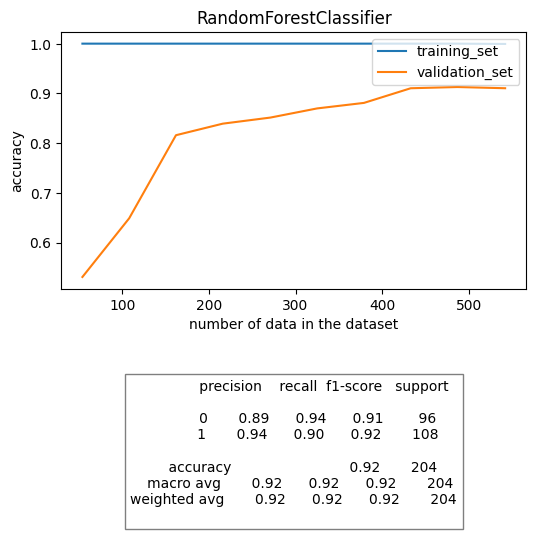

evaluation of AdaBoost (2/4):


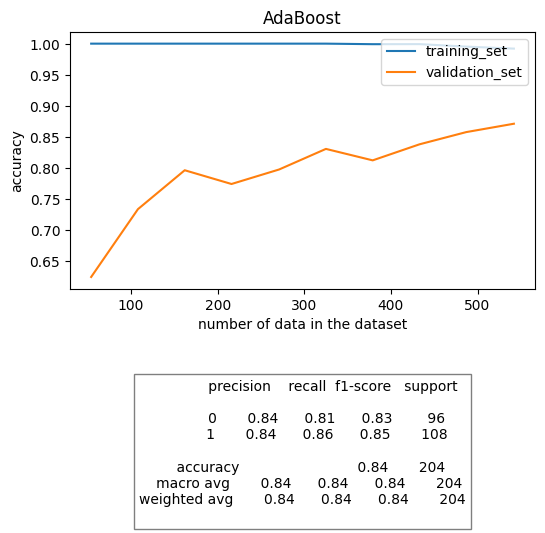

evaluation of SVM (3/4):


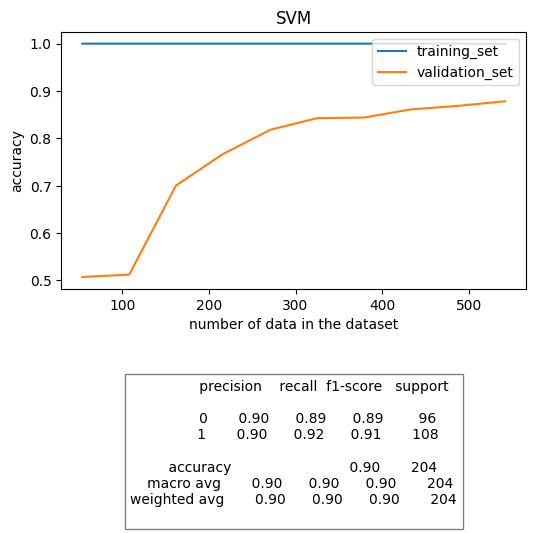

evaluation of MLP (4/4):


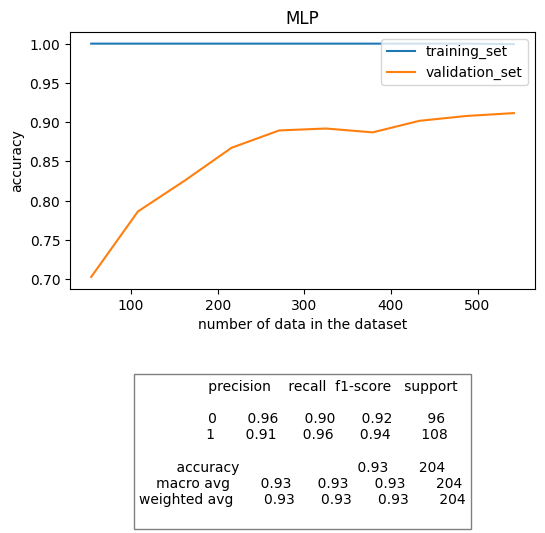

In [58]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# try different models for classification
RandomForestC = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=0)
SVM = SVC(random_state=0) # Support Vector Machine
MLP = MLPClassifier(random_state=0) # Multi-Layer Perceptron

# associate each model with its name
dict_of_models = {'RandomForestClassifier': RandomForestC, 'AdaBoost': AdaBoost, 'SVM': SVM, 'MLP': MLP}

nb_model = len(dict_of_models)
current_model = 1
# evaluation of classifier models
for name, model in dict_of_models.items():
    print(f'evaluation of {name} ({current_model}/{nb_model}):')
    model.fit(X_train, Y_train)
    evaluation_classification(model, name, X_train, X_test, Y_train, Y_test)
    current_model += 1

# execution time ~ 8-10min

<h3> 4- Upgrade Our Best Model (RandomForest) </h3>

In [59]:
from sklearn.model_selection import GridSearchCV

# hyperparameter tuning for RandomForestClassifier (the more promising model)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# find the best parameters for the model RandomForestClassifier
grid_search = GridSearchCV(RandomForestC, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, Y_train)
y_pred = grid_search.predict(X_test)

# display the results
print(grid_search.best_params_)
print("\nclassification_report :\n")
print(classification_report(Y_test, y_pred))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

classification_report :

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        96
           1       0.93      0.91      0.92       108

    accuracy                           0.92       204
   macro avg       0.92      0.92      0.92       204
weighted avg       0.92      0.92      0.92       204

